In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
num_classes = ds_info.features["label"].num_classes

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


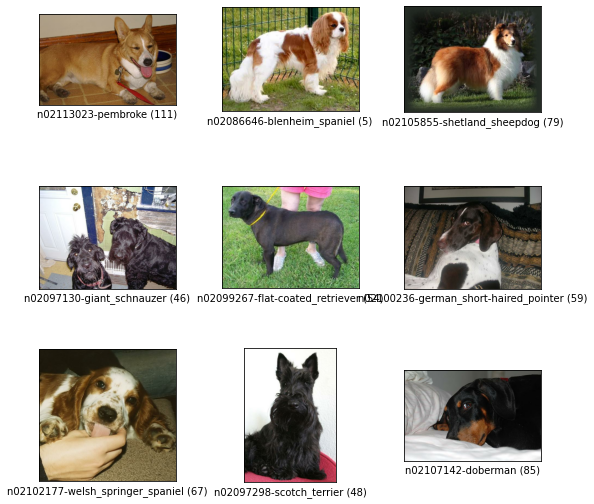

In [3]:
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)

    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, 
           label, 
           prob = 1.0, 
           batch_size=16, 
           img_size=224, 
           num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image, 
           label, 
           prob = 1.0, 
           batch_size=16, 
           img_size=224,
           num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

In [13]:
def dataset(ds, 
                               is_test=False, 
                               batch_size=16, 
                               with_aug=False, 
                               with_cutmix=False, 
                               with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: 
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [15]:
ds_train_no_aug = dataset(ds_train, with_aug=False)
ds_train_aug = dataset(ds_train, with_aug=True)
ds_train_cutmix = dataset(ds_train, with_cutmix=True)
ds_train_mixup = dataset(ds_train, with_mixup=True)
ds_test = dataset(ds_test, is_test = True)

In [16]:
tf.random.set_seed(2020)

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
h_resnet50 = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 206ms/step - loss: 2.2313 - accuracy: 0.4386 - val_loss: 3.7816 - val_accuracy: 0.1622
Epoch 2/20
750/750 [==============================] - 153s 205ms/step - loss: 0.6966 - accuracy: 0.8106 - val_loss: 0.9894 - val_accuracy: 0.7053
Epoch 3/20
750/750 [==============================] - 169s 225ms/step - loss: 0.2203 - accuracy: 0.9548 - val_loss: 0.9192 - val_accuracy: 0.7269
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0714 - accuracy: 0.9926 - val_loss: 0.9428 - val_accuracy: 0.7295
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0283 - accuracy: 0.9990 - val_loss: 0.9040 - val_accuracy: 0.7429
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0176 - accuracy: 0.9994 - val_loss: 0.9152 - val_accuracy: 0.7472
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0121 - accuracy: 0.9996 - val_loss: 0.9316 -

### Basic augmetaion

In [20]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [22]:
h_basic_aug_resnet50 = basic_aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 206ms/step - loss: 2.2128 - accuracy: 0.4437 - val_loss: 2.9443 - val_accuracy: 0.2807
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9426 - accuracy: 0.7261 - val_loss: 1.2958 - val_accuracy: 0.6312
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.5037 - accuracy: 0.8597 - val_loss: 1.1023 - val_accuracy: 0.6826
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2402 - accuracy: 0.9451 - val_loss: 1.1373 - val_accuracy: 0.6828
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1289 - accuracy: 0.9772 - val_loss: 0.9641 - val_accuracy: 0.7291
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0652 - accuracy: 0.9908 - val_loss: 0.9321 - val_accuracy: 0.7406
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0431 - accuracy: 0.9948 - val_loss: 0.9351 -

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [25]:
h_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.8490 - accuracy: 0.2058 - val_loss: 3.8908 - val_accuracy: 0.1477
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9250 - accuracy: 0.4363 - val_loss: 1.3067 - val_accuracy: 0.6456
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.6112 - accuracy: 0.5306 - val_loss: 1.2012 - val_accuracy: 0.6615
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4541 - accuracy: 0.5878 - val_loss: 1.3224 - val_accuracy: 0.6428
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2760 - accuracy: 0.6440 - val_loss: 1.2072 - val_accuracy: 0.6597
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1354 - accuracy: 0.6873 - val_loss: 1.2495 - val_accuracy: 0.6659
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 2.0713 - accuracy: 0.7094 - val_loss: 1.1677 -

In [26]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
h_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.7228 - accuracy: 0.2445 - val_loss: 4.2440 - val_accuracy: 0.0875
Epoch 2/20
750/750 [==============================] - 169s 226ms/step - loss: 2.8695 - accuracy: 0.4789 - val_loss: 2.1540 - val_accuracy: 0.4499
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.5580 - accuracy: 0.5968 - val_loss: 1.4519 - val_accuracy: 0.5982
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3852 - accuracy: 0.6574 - val_loss: 1.5252 - val_accuracy: 0.5829
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2440 - accuracy: 0.7117 - val_loss: 1.2478 - val_accuracy: 0.6552
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1411 - accuracy: 0.7519 - val_loss: 1.1583 - val_accuracy: 0.6834
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0616 - accuracy: 0.7763 - val_loss: 1.2358 -

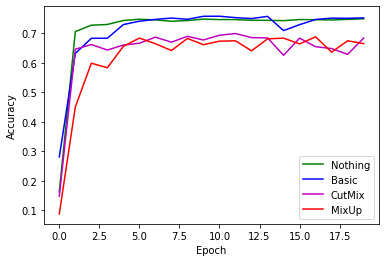

In [29]:
plt.plot(h_resnet50.history['val_accuracy'], 'g')
plt.plot(h_basic_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(h_cutmix_resnet50.history['val_accuracy'], 'm')
plt.plot(h_mixup_resnet50.history['val_accuracy'], 'r')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Nothing', 'Basic', 'CutMix', 'MixUp'], loc='lower right')
plt.show()

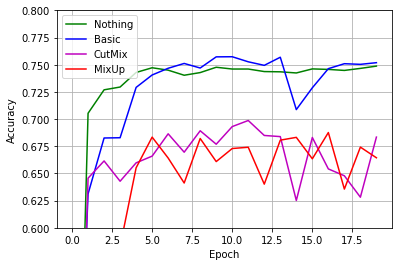

In [30]:
plt.plot(h_resnet50.history['val_accuracy'], 'g')
plt.plot(h_basic_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(h_cutmix_resnet50.history['val_accuracy'], 'm')
plt.plot(h_mixup_resnet50.history['val_accuracy'], 'r')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Nothing', 'Basic', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)
plt.show()